# Project Overview

The goal of this project was to develop a fraud classifier for an e-commerce company that sells handmade clothes. The dataset consists of ~150k transactions. A table of contents is as follows:

1. Data Processing: Detemining Country from IPAddress
2. Feature Engineering / Preprocessing
3. Machine Learning (Training)
4. Gaining Insights from the ML Model
5. Building a Product from the ML Model

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, partial_dependence
from sklearn.metrics import roc_curve, auc
from sklearn import tree
import graphviz

%matplotlib inline

In [2]:
users = pd.read_csv("Fraud_Data.csv")
ips = pd.read_csv("IpAddress_to_Country.csv")

In [3]:
users.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
users.user_id.nunique() == len(users)

True

In [5]:
ips.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


## Data Processing: Determine Country Based on IP Address

In [6]:
users['country'] = np.nan

#caution: this code takes a long time (~10 min) to run
for i in range(len(users)):
    try:
        #to get value: filter by upper and lower bound, then select just the value of the resultant Series.
        users.loc[i, 'country'] = ips[(ips.lower_bound_ip_address <= users.loc[i, 'ip_address']) \
                              & (ips.upper_bound_ip_address >= users.loc[i, 'ip_address'])].country.values[0]
    except:
        #some ips are not within known country bounds. skipping over these will leave null value
        pass
    #because this code took about 10 min to run, I have it print status at roughly 1% completion intervals
    if i % 1511 == 0:
        print('{}% complete'.format(np.round(i/len(users)*100)))

0.0% complete
1.0% complete
2.0% complete
3.0% complete
4.0% complete
5.0% complete
6.0% complete
7.0% complete
8.0% complete
9.0% complete
10.0% complete
11.0% complete
12.0% complete
13.0% complete
14.0% complete
15.0% complete
16.0% complete
17.0% complete
18.0% complete
19.0% complete
20.0% complete
21.0% complete
22.0% complete
23.0% complete
24.0% complete
25.0% complete
26.0% complete
27.0% complete
28.0% complete
29.0% complete
30.0% complete
31.0% complete
32.0% complete
33.0% complete
34.0% complete
35.0% complete
36.0% complete
37.0% complete
38.0% complete
39.0% complete
40.0% complete
41.0% complete
42.0% complete
43.0% complete
44.0% complete
45.0% complete
46.0% complete
47.0% complete
48.0% complete
49.0% complete
50.0% complete
51.0% complete
52.0% complete
53.0% complete
54.0% complete
55.0% complete
56.0% complete
57.0% complete
58.0% complete
59.0% complete
60.0% complete
61.0% complete
62.0% complete
63.0% complete
64.0% complete
65.0% complete
66.0% complete
67.0%

In [7]:
#replace nulls w/ 'unknown' to be included in the count
users.country.fillna('Unknown', inplace=True)
users.groupby('country').user_id.count().sort_values(ascending=False)

country
United States                           58049
Unknown                                 21966
China                                   12038
Japan                                    7306
United Kingdom                           4490
Korea Republic of                        4162
Germany                                  3646
France                                   3161
Canada                                   2975
Brazil                                   2961
Italy                                    1944
Australia                                1844
Netherlands                              1680
Russian Federation                       1616
India                                    1310
Taiwan; Republic of China (ROC)          1237
Mexico                                   1121
Sweden                                   1090
Spain                                    1027
South Africa                              838
Switzerland                               785
Poland                    

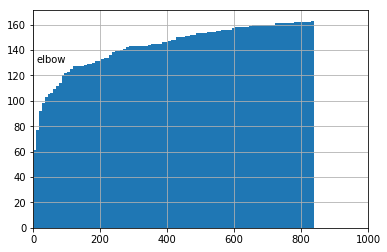

In [8]:
country_counts = users.groupby('country').user_id.count()
ax = country_counts[country_counts <=1000].hist(cumulative=True,bins=100)
ax.set_xlim(0, 1000)
ax.annotate('elbow', xy=(100, 120), xytext=(10, 130))

## Feature Engineering / Preprocessing

In [9]:
users.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States


Feature to measure number of users in that country:

In [10]:
users['country_users'] = users.groupby('country').user_id.transform('nunique')

Features to measure 1) number of (unique) users per a certain device id and 2) number of (unique) users per ip_address:

In [11]:
users['device_users'] = users.groupby('device_id').user_id.transform('nunique')
users['ip_users'] = users.groupby('ip_address').user_id.transform('nunique')

Feature to measure time between signup and first purchase:

In [12]:
users['signup_time'] = pd.to_datetime(users['signup_time'])
users['purchase_time'] = pd.to_datetime(users['purchase_time'])
users['time_delta_s'] = (users['purchase_time'] - users['signup_time']).dt.total_seconds()

In [13]:
#users that bought something within 5 seconds of signing up!
tds = users.time_delta_s
tds[tds <= 5].count()

7600

A few last features to check for seasonality

In [14]:
users['signup_DOW'] = users['signup_time'].dt.dayofweek
users['signup_week'] = users['signup_time'].dt.week

users['purchase_DOW'] = users['purchase_time'].dt.dayofweek
users['purchase_week'] = users['purchase_time'].dt.week

users.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,country_users,device_users,ip_users,time_delta_s,signup_DOW,signup_week,purchase_DOW,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,7306,1,1,4506682.0,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,58049,1,1,17944.0,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,58049,12,12,1.0,3,1,3,1


Create ML datasets:

In [15]:
users.rename(columns={'class': 'is_fraud'}, inplace=True)

In [16]:
X = users.drop(['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address', 'is_fraud', 'country'], axis=1)
X = pd.get_dummies(X, columns=['source', 'browser', 'sex'])
X = X.drop('sex_F', axis=1)
y = users.is_fraud

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)

## Machine Learning

Fit a Random Forest classifer.  I chose random forest because it is fairly quick to optimize and insensitive to outliers and irrelevant variables. 

In [17]:
rf = RandomForestClassifier(n_estimators=50, min_samples_leaf=.001)
rf.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.001, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:
rf.score(Xtrain, ytrain)

0.95645597383198777

In [19]:
rf.score(Xtest, ytest)

0.95672122468787224

Note: For the sake of simplicity of this project, I am not **optimizing hyperparameters** of the random forest. If my goal was to get the absolute best performance out of the model, I would do a full cross-validated grid search to optimize. The hyperparameters that I would include in the grid search are:
* max depth of tree
* max features to consider at each split
* minimum number of sample required to be at a leaf node
* criterion (cost function, ie. entropy vs gini)
* number of trees (estimators) in forest

In [20]:
1 - ytrain.mean()

0.9064266671708673

Even when comparing score to guessing everything as "not fraud", the random forest classifier is a ~5% improvement (looking at test set score). However, this brings up the point that acccuracy can be misleading -- classifying everything as not fraud could yield high accuracy, but offer no help in solving the business problem.

This leads us to the ROC Curve, where we can see how cutoff values will impact false positives and false negatives (as well as tp and tn).

In [21]:
y_score = rf.predict_proba(Xtest)[:,-1]
y_true = ytest
fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)
roc_auc = auc(fpr, tpr)

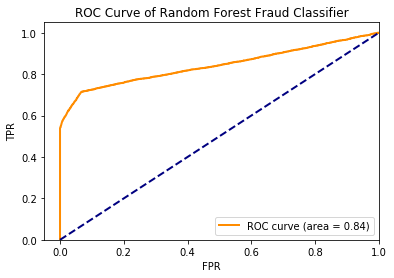

In [22]:
plt.figure()
lw=2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve of Random Forest Fraud Classifier')
plt.legend(loc='lower right')
plt.show()

With no knowledge of the cost of false positives or false negatives the optimal points would be:
* For minimizing false positive rate - Pick the cut-off that corresponds to the point in the elbow region where FPR = 0, TPR = ~0.55
* For maximizing true positive rate - decrease cut-off and choose a point along the line from ~(0.1,0.7) to (1,1)

In this case, we don't explicitly know the cost of false positives or false negatives, but we can make some reasonable assumptions. In our example:
* False positive means a customer is incorrectly flagged as a fraudulent user. This might not be so bad as long the classifier just triggers an additional verification step for users marked as positive by the model.
* False negative means a someone committing fraud will go undetected by the classifier. This is most likely a more serious error for the classifier to make

* Given that false negatives are assumed to be much more costly, we should pick a point towards the upper right part of the ROC curve. More false alarms will be triggered, but virtually all fraudulent transactions will be caught.

## Gaining Insights from the ML Model

First, I'll plot feature importance from Random Forest model

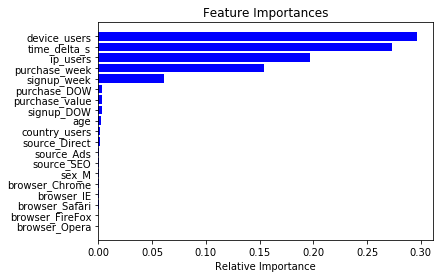

In [23]:
importances = rf.feature_importances_
features = X.columns
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

From the feature importances above, we can take the top 5 and plot partial dependence plots. At the moment in Python, this needs to be done with a gradient boosting model. That's ok, I'll just fit a gradient boosting classifier quickly before creating the PDP's.

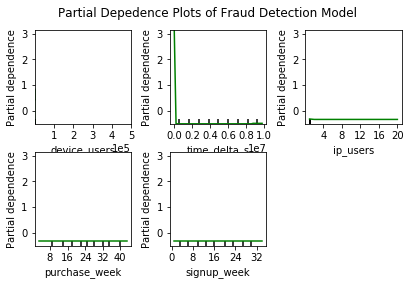

In [24]:
gb = GradientBoostingClassifier(n_estimators=10).fit(X,y)

indices_desc = indices[::-1]
features = indices_desc[:5]
feature_names = X.columns[features]

fig, axs = partial_dependence.plot_partial_dependence(gb, X, features,
                                                     feature_names=X.columns,
                                                     n_jobs=3, grid_resolution=50)
fig.suptitle('Partial Depedence Plots of Fraud Detection Model')
#adjust xlim to see the trend more clearly
axs[0].set_xlim(0,5e5)
plt.subplots_adjust(top=0.9)

The partial dependence plots show strong trends for time delta between signing up and purchasing, as well as # of devices per user. The two takeaways are:
* A small time delta between signup and transaction is a really strong indicator of fraud
* A device used by multiple users is also a strong indicator of fraud

Lastly, I'll fit a simple decision tree to observe splits and visualize importance of features

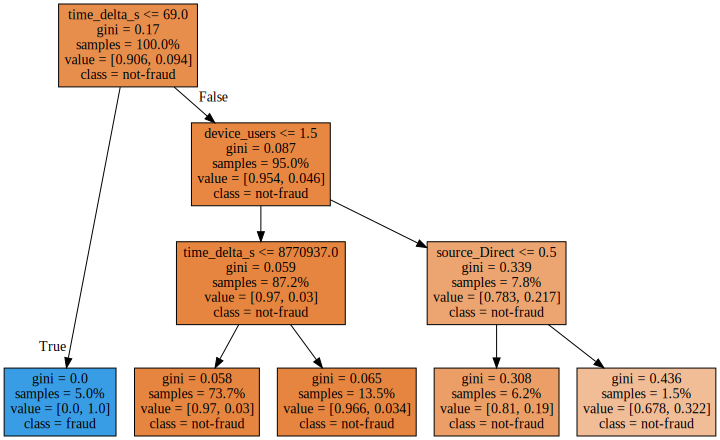

In [25]:
dt = tree.DecisionTreeClassifier(max_depth=3)
dt.fit(X,y)
dot_data = tree.export_graphviz(dt, out_file=None, feature_names=X.columns, class_names=['not-fraud', 'fraud'],
                     proportion=True, leaves_parallel=True, filled=True)
graphviz.Source(dot_data)

The decision tree again shows that "time delta" and number of device users are the strong features in our classifier.

## Building a Product from the ML Model

ML models are most useful when they can be integrated into a product to take advantage of the positives of the model while hiding the drawbacks. In this case, if I was to deploy this ML model to predict fraudulent transactions, I could look at the classifier's predicted probabilities -- PR(Y|X) -- to assess the risk of a user. In fact I could choose more than one threshold and route user to a certain experience as follows:
* **PR(Y|X) < Theshold1: Low-risk users**, normal experience; no special action needed. This will be the experience for most users
* **Threshold1 <= PR(Y|X) <= Threshold2: Medium-risk users**, can prompt them for additional verification step or security question
* **PR(Y|X) > Threshold2: High-risk users**, can freeze account until user calls in for verification or have someone manually reviewing cases like this